In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pylab as plt

In [11]:
# read in the data
integrals = pd.read_csv('../data/integrals_20170323.txt',sep=',',header=None)
integral_ranges = pd.read_csv('../data/coculture_peak_ranges.txt',sep=',')
master = pd.read_csv('../data/merged_metadata.txt',sep='\t')

In [12]:
integrals.columns = integral_ranges['met_name']
mets = integrals.columns # grab metabolite names for future use
integrals['experiment_id'] = master['experiment_id']
all_data = pd.merge(master,integrals,on='experiment_id')

#remove non-growing samples
all_data = all_data.loc[~((all_data['Run'] == 2) & (all_data['species'].str.find('502') > -1))]
all_data = all_data.loc[~((all_data['Run'] == 3) & (all_data['species'].str.find('502') > -1))]
all_data = all_data.loc[~((all_data['Run'] == 3) & (all_data['species'].str.find('500') > -1))]
all_data = all_data.loc[~((all_data['Run'] == 3) & (all_data['species'].str.find('492') > -1))]
# remove run 4
all_data = all_data.loc[~(all_data['Run'] == 4)]

In [13]:
# Set negative values as 0
all_data[mets] = all_data[mets].clip(0)
# scale all metabolites by their max value
all_data[mets] = all_data[mets]/all_data[mets].max()

In [14]:
# Get the initial concentration of all metabolites using the blanks
init_conc = all_data.loc[all_data['species'] == '0'][mets].mean()

# For each species, calculate the change of the metabolite per unit biomass
ratios = {}
species = ['356','360','361','492','500','519']
for specie in species:
    ratios[specie] = {}
    for met in mets:
        init = init_conc[met]
        final = all_data.loc[all_data['species'] == specie][met].mean()
        qpcr_name = [col for col in all_data.columns if col.find(specie) > -1]
        abundance = all_data.loc[all_data['species'] == specie][qpcr_name].mean().values[0]
        ratio = (final - init)/abundance
        ratios[specie][met] = ratio
# convert to dataframe
ratios = pd.DataFrame(ratios)

In [15]:
# for each species pairing, generate a linear model to infer an interaction term
species_used = []
for species_1 in species:
    species_1_qpcr = [col for col in all_data.columns if col.find(species_1) > -1]
    species_1_subset = all_data.loc[all_data['species'].str.find(species_1) > -1]
    species_used.append(species_1)
    for species_2 in species:
        if species_2 not in species_used:
            species_2_qpcr = [col for col in all_data.columns if col.find(species_2) > -1]
            
            # get the abundance of each species in every sample
            samples = species_1_subset.loc[species_1_subset['species'].str.find(species_2) > -1]
            species_1_abundances = samples[species_1_qpcr]
            species_2_abundances = samples[species_2_qpcr]
            for met in mets:
                final_conc = samples[met]
                conc_change = final_conc - init_conc[met]
                expected_change_species_1 = (species_1_abundances * ratios.loc[met,species_1]).transpose().values[0]
                expected_change_species_2 = (species_2_abundances * ratios.loc[met,species_2]).transpose().values[0]
                total_expected = np.add(expected_change_species_1,expected_change_species_2)
                total_with_init = np.subtract(conc_change, total_expected)
                
                

In [16]:
clf = linear_model.Lasso()
clf.fit(total_expected.reshape(-1,1),conc_change.reshape(-1,1))

/home/greg/Envs/cobra6/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [17]:
clf.intercept_

array([-0.2267071])

/home/greg/Envs/cobra6/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


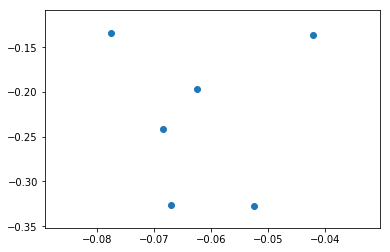

In [18]:
fig,ax = plt.subplots()
ax.scatter(x=total_expected.reshape(-1,1),y=conc_change.reshape(-1,1))

In [21]:
np.mean(total_expected)

-0.06171823935444009

In [22]:
np.mean(conc_change)

-0.22670710279923942